# Third part of the architecture for gaze target detection in the wild

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
import torch
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import time
import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


## At the end of the 3D Gaze Estimator

In [2]:
def planar_angular_loss(dx, dy, gx, gy):
    """
        d=(dx, dy) : ground truth planar gaze direction
        g=(gx, gy) : 2D projection of the estimated 3D gaze direction
    
    """
    
    res = 1 - (dx*gx+dy*gy)/(((dx**2 + dy**2)**(1/2))*(gx**2 + gy**2)**(1/2))    
    
    return res 

## Dual Attention Mode

In [3]:
def Dual_attention_mode(Mf, Md):
    """
        Mf : FOV   Attention Map
        Md : Depth Attention Map
        
        return -> Mdual : Dual Attention Map 
    """
    return Mf*Md

# Pytorch

### Backbone part (don't forget to activate)

In [4]:
# ResNet50
import torchvision.models as models
backbone = models.resnet50(pretrained=True, progress=True)
print("ResNet50 loaded")
# Freeze the learning of the layers of the resnet50
for param in backbone.parameters():
    param.requires_grad = False

ResNet50 loaded


In [5]:
#from torchsummary import summary

#out_ftrs, in_ftrs, bias_ftrs = backbone.fc.out_features, backbone.fc.in_features, len(backbone.fc.bias)

#print("Parameters of the last layer of the backbone : "out_ftrs, ",", in_ftrs, ",", bias_ftrs)
#print("\n")
#print(summary(backbone, (3,224,224)))

In [6]:
# To prepare the data if necessary but normaly it's not
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

### Binary Classification Head

In [7]:
def concat(p1, p2, axis=0):
    """
        p1, p2 : already tensors
        axis   : 0 for raw, 1 for columns
        
        Concatenation of the two pictures of the entry
    """
    return tf.concat([p1, p2], 0)

In [8]:
class binary(nn.Module):
    def __init__(self):
        super(binary, self).__init__()
        
        #Resnet
        self.backbone = backbone
        
        #convolution layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding="same")
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding="same")

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=1000, out_features=2)
        
    # x represents our data
    def forward(self, x):
        x = self.backbone(x)
        
        x = x.unsqueeze(dim=1) #unsqueeze by adding the second dimension (in_channels=1)
        x = self.conv1(x)

        x = self.conv2(x)
        x = x.squeeze(dim=1)
        x = self.fc1(x)
        
        output = F.log_softmax(x, dim=1)
        return output

##########################################################
#  Only a simple test on the Binary Classification Head  #
##########################################################    

# Equates to one random 448x224 image
random_data = torch.rand((1, 3, 224+224, 224))

my_nn = binary()
result = my_nn(random_data)
print(result)

tensor([[-0.6102, -0.7836]], grad_fn=<LogSoftmaxBackward>)


### Heatmap Regression Head

[[[0.00024308 0.00023968 0.0002511  ... 0.00023887 0.00025564 0.00023493]
  [0.00025321 0.00023972 0.00025239 ... 0.00024265 0.0002531  0.00022989]
  [0.00024997 0.00024179 0.0002548  ... 0.00024353 0.00025236 0.00022932]
  ...
  [0.00025052 0.00024165 0.00025709 ... 0.00024502 0.00024965 0.00022637]
  [0.00024662 0.00024346 0.00025532 ... 0.00023802 0.00025078 0.00023176]
  [0.00025254 0.00024078 0.0002554  ... 0.00023954 0.00025309 0.00024196]]]


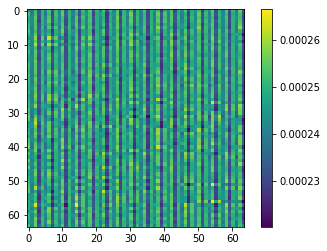

In [9]:
class h_reg(nn.Module):
    def __init__(self):
        super(h_reg, self).__init__()
        
        #Resnet
        self.backbone = backbone
        
        #convolution layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=10, stride=2, padding=6)
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=6)

        # Fully connected layer
        self.downsample1 = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.downsample2 = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.downsample3 = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        
        
    # x represents our data
    def forward(self, x):

        x = self.backbone(x)
       
        x = x.unsqueeze(dim=1) 
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.downsample1(x)
        x = self.downsample2(x)
        x = self.downsample3(x)
        
        x = x.squeeze(dim=1)

        output = F.softmax(x, dim=1)
        output = output.reshape(1, 64, 64)
        
        return output

    
##########################################################
#   Only a simple test on the Heatmap Regression Head    #
##########################################################

# Equates to one random 448x224 image
random_data = torch.rand((1, 3, 224+224, 224))

my_nn = h_reg()
result = my_nn(random_data)

result = result.detach().numpy() 
print(result)

plt.imshow(result[0,:,:])
plt.colorbar()
plt.show()

### Train function for both of the models

In [ ]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):
    
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))


    history             = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss']     = []
    history['val_loss'] = []
    history['acc']      = []
    history['val_acc']  = []

    start_time_sec = time.time()


    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss         = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 10 == 0:
            print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
            (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

cc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()